In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [42]:
df = pd.read_csv('NVDA_Stock.csv', parse_dates=['Date'], index_col='Date')
cols = ['Close', 'Open', 'High', 'Low']

# pass them to df.replace(), specifying each char and it's replacement:
df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)
df[cols] = df[cols].astype('float64')
# Display the first few rows
print(df.head())

# Feature engineering: use historical prices to predict future prices
df['Target'] = df['Close'].shift(-1)  # Predict the next day's closing price

# Drop rows with NaN values (from shifting)
df.dropna(inplace=True)

# Select features and target
features = df[['Close']].values
target = df['Target'].values

# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


# Create sequences for LSTM input
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
SEQ_LENGTH = 10

X, y = create_sequences(features_scaled, target, SEQ_LENGTH)

# Split into training and test sets
# Define the LSTM model
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.2)

# Save the model
model.save('stock_predictor_model.h5')

# Make predictions
predictions = model.predict(X)

# Inverse transform the predictions and true values
predictions = scaler.inverse_transform(predictions)
y_true = scaler.inverse_transform(y.reshape(-1, 1))

             Close     Volume     Open    High     Low
Date                                                  
2024-09-10  108.10  268283700  107.810  109.40  104.95
2024-09-09  106.47  273912000  104.880  106.55  103.69
2024-09-06  102.83  413638100  108.040  108.15  100.95
2024-09-05  107.21  306850700  104.985  109.65  104.76
2024-09-04  106.21  372470300  105.410  113.27  104.12
Epoch 1/30
63/63 [==============================] - 4s 16ms/step - loss: 894.6097 - val_loss: 111.1906
Epoch 2/30
63/63 [==============================] - 0s 8ms/step - loss: 724.6427 - val_loss: 180.2068
Epoch 3/30
63/63 [==============================] - 0s 8ms/step - loss: 685.0481 - val_loss: 7.7144
Epoch 4/30
63/63 [==============================] - 1s 8ms/step - loss: 592.2144 - val_loss: 1.3589
Epoch 5/30
63/63 [==============================] - 1s 8ms/step - loss: 539.7464 - val_loss: 1.4549
Epoch 6/30
63/63 [==============================] - 1s 8ms/step - loss: 497.2854 - val_loss: 2.5643
Epoch 7/30

C:\Users\Konstantinos\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 1s 4ms/step


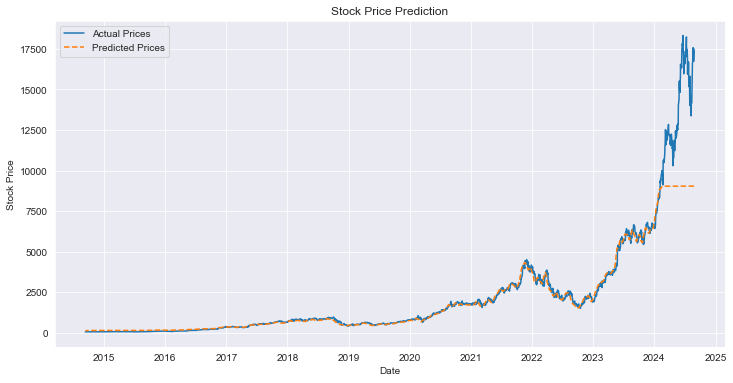

In [43]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[SEQ_LENGTH:], y_true, label='Actual Prices')
plt.plot(df.index[SEQ_LENGTH:], predictions, label='Predicted Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()